In [1]:
#>> updated 4/1
# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import nltk
import spacy
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries
from scipy import stats
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}') #<< faster than doing api.load
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = False
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = True

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

Amazon reviews file: /kaggle/input/amazon-product-reviews/Reviews.csv
Google news word to vec file: /kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
## Only run once
#>> Seems to need to be rerun after every Kaggle timeout.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Amazon reviews loaded into Panda
VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3 

In [4]:
# Check for empty entries or missing data in each column
for column in data.columns:
    if data[column].isnull().values.any():
        print(f"Column '{column}' has empty entries or missing data.")
    else:
        print(f"Column '{column}' has no empty entries or missing data.")

Column 'Id' has no empty entries or missing data.
Column 'ProductId' has no empty entries or missing data.
Column 'UserId' has no empty entries or missing data.
Column 'ProfileName' has empty entries or missing data.
Column 'HelpfulnessNumerator' has no empty entries or missing data.
Column 'HelpfulnessDenominator' has no empty entries or missing data.
Column 'Score' has no empty entries or missing data.
Column 'Time' has no empty entries or missing data.
Column 'Summary' has empty entries or missing data.
Column 'Text' has no empty entries or missing data.


52,268 samples from balanced data with rating 1

29,769 samples from balanced data with rating 2

42,640 samples from balanced data with rating 3

80,655 samples from balanced data with rating 4

363,122 samples from balanced data with rating 5



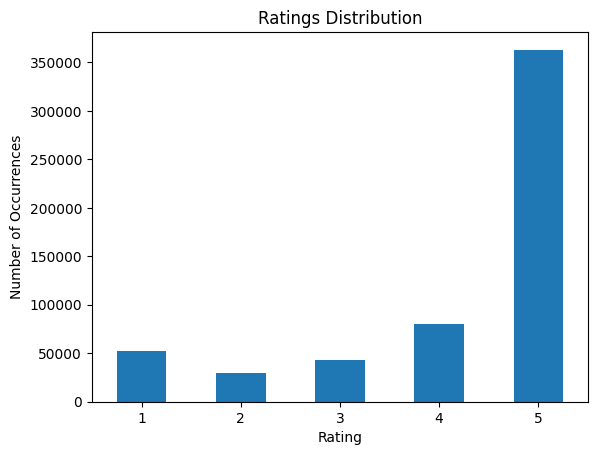

In [5]:
# Get count of ratings 
rating_counts = data['Score'].value_counts()

# Sort counts by index ascending
rating_counts = rating_counts.sort_index()  

# Create bar plot
ax = rating_counts.plot(kind = 'bar')

ax.set_title("Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Occurrences")

# Fix x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show() #<< show the rating in each of the 5 categories

/tmp/ipykernel_23/1469423797.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))


VERBOSE: The number of reviews equally distributed across all ratings is 140000
28,000 samples from balanced data with rating 1

28,000 samples from balanced data with rating 2

28,000 samples from balanced data with rating 3

28,000 samples from balanced data with rating 4

28,000 samples from balanced data with rating 5



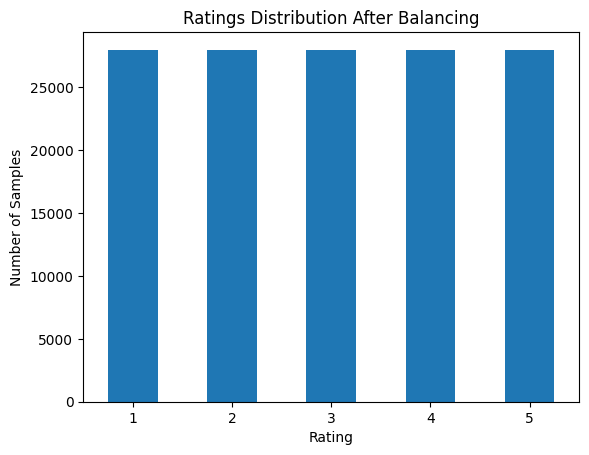

In [6]:
balanced_data_size = 28000 #<< number of reviews in each rating category, tailored for CPU capacity
# Specify the column for sorting and balancing
sort_column = 'Score'  # This is one the rating column

# Sort the data by the rating values
sorted_data = data.sort_values(by = sort_column)

# Create a balanced dataset with 25,000 samples from each class
#balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n=25000))

#>> DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 
#>> This behavior is deprecated, and in a future version of pandas the grouping 
#>> columns will be excluded from the operation. 
#>> Either pass `include_groups=False` to exclude the groupings or 
#>> explicitly select the grouping columns after groupby to silence this warning.
#
balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))

#>> Does this mean to reset the row numbers?? ##Columns Numbers
balanced_data.reset_index(drop = True, inplace = True)

printv(f"The number of reviews equally distributed across all ratings is {len(balanced_data['Score'])}")

# Get count of ratings
rating_counts = balanced_data['Score'].value_counts()

# Create bar plot
ax = rating_counts.plot(kind='bar')

ax.set_title("Ratings Distribution After Balancing")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Samples")

# Fix x-axis ticks  
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

# Print number of reviews per rating

if DEV:
    for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show()

In [7]:
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.9 MB/s eta 0:00:00
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=50428 sha256=b6d675400d48cb38049191736f34843edfca4deb121e318ed0769b730ed21553
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [8]:
custom_stop_words =['d', 'i', "it's", 'll', 'm', 'ma', 'most', 'mustn', 
"mustn't", 'needn', "needn't", 'o','re', 's', "she's", 'so', 'some', 'such',
't', "that'll", 've', 'wasn', "wasn't", 'y', 'you', "you'd", "you'll", "you're"
, "you've", 'yourselves', ' ']

In [9]:
# custom stop words to remove
# custom_stop_words =['a', 'about', 'above', 'after',  'all', 'am', 'an', 'and', 'any',
# 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
# 'between', 'both', 'but', 'by', 'can',  'd', 'did',
#  'do', 'does', 'doing', 'down',
# 'during', 'each', 'for', 'from', 'further', 'had', 'has',  'have', 'having',
# 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how',
# 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its',
# 'itself', 'just', 'll', 'm', 'ma', 'me',  'more',
# 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't",
# 'nor',  'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
# 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's',
# 'same',  'she', "she's", 'so', 'some', 'such', 't', 'than', 'that',
# "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
# 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too',
# 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
# 'were',  'what', 'when', 'where', 'which', 'while',
# 'who', 'whom', 'why', 'will', 'with', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your',
# 'yours', 'yourself', 'yourselves', ' ']

**Around 7 minutes for 5,000 reviews**

In [10]:
import pkg_resources
from symspellpy import SymSpell

# Load the English tokenizer model from spaCy
nlp = spacy.load("en_core_web_lg")

# Compile the regular expressions for cleaning text
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')

# Initialize and load SymSpell dictionary for word segmentation
sym_spell = SymSpell(max_dictionary_edit_distance = 0, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

def tokenizer(text, nlp, sym_spell, custom_stop_words):
    """
    Tokenizes a text string, segments run-on words, and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The spaCy language model.
    sym_spell: The SymSpell object for correcting run-on words.
    custom_stop_words (list): A list of custom stop words to remove.

    Returns:
        list: The tokenized text string.
    """
    # Clean text
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    # text = punct_and_symbols.sub("", text)  # Replace punctuation and symbols with space
    text = punct_and_symbols.sub(" ", text)  # Replace punctuation and symbols with space

    # Segment text using SymSpell
    segmented = sym_spell.word_segmentation(text)
    clean_text = segmented.corrected_string
    
    # Tokenize the text using spaCy
    doc = nlp(clean_text)

    # Remove stop words and punctuation tokens
    tokens = [token.text for token in doc if not token.is_punct 
              and token.text not in custom_stop_words] 

    return tokens

# Assuming 'balanced_data' is a pandas DataFrame with a column 'Text'
# Apply the tokenizer function to the 'Text' column
balanced_data['CleanedReview'] = balanced_data['Text'].apply(lambda x: tokenizer(x, nlp, sym_spell, custom_stop_words))

# Indicate completion
print('Tokenizer defined, and CleanedReview column created')

Tokenizer defined, and CleanedReview column created


In [11]:
# Store the Rating column
rating = balanced_data['Score']  

# Store the CleanedReview column
tokenized_review = balanced_data['CleanedReview']
showD(f'specify the columns that will be used to train the classifier')

for i in range (5):
    print(balanced_data['Text'][i],'\n')
    print(tokenized_review[i], '\n')
    print(len(tokenized_review[i]), '\n')
    print(tokenized_review.shape)

VERBOSE: specify the columns that will be used to train the classifier
My daughter is a strawberry fiend so I thought this would be perfect for her, but she just spits every bite out pretty violently, LOL! I tried it myself in exasperation and it really tasted like a spoonful of strawberry jam. GROSS. 

['my', 'daughter', 'is', 'a', 'strawberry', 'fiend', 'thought', 'this', 'would', 'be', 'perfect', 'for', 'her', 'but', 'she', 'just', 'spits', 'every', 'bite', 'out', 'pretty', 'violently', 'lol', 'tried', 'it', 'myself', 'in', 'exasperation', 'and', 'it', 'really', 'tasted', 'like', 'a', 'spoonful', 'of', 'strawberry', 'jam', 'gross'] 

39 

(140000,)
Includes tune oil, gelatin and vitamins. I would expect organic pea pure to include just peas, but this is not the case. Enough said. Deleting my subscription. 

['includes', 'tune', 'oil', 'gelatin', 'and', 'vitamins', 'would', 'expect', 'organic', 'pea', 'pure', 'to', 'include', 'just', 'peas', 'but', 'this', 'is', 'not', 'the', 'case',

Mean: 88.08
Median: 63.00
Mode: ModeResult(mode=24, count=1981)


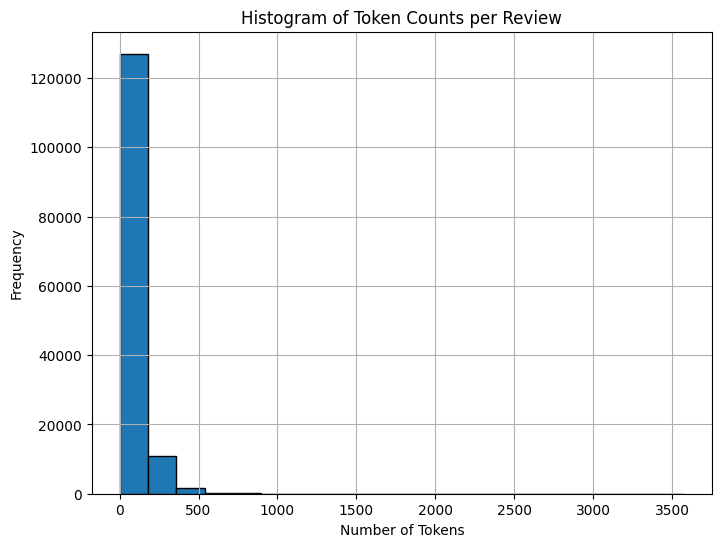

In [12]:
def analyze_review_tokens(reviews):
    token_counts = [len(review) for review in reviews]

    mean = np.mean(token_counts)
    median = np.median(token_counts)
    mode = stats.mode(token_counts)

    print(f"Mean: {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Mode: {mode}")

    plt.figure(figsize=(8, 6))
    plt.hist(token_counts, bins=20, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Histogram of Token Counts per Review')
    plt.grid(True)
    plt.show()

analyze_review_tokens(tokenized_review)

In [13]:
# >> 3/29/24 Took less than a minute to run without the accelerator.
# Load Word2Vec model
#w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

# Define the aimum sequence length (adjust as needed)
#>> Will increasing max_sequence_length impact performance?
max_sequence_length = 100

showD(f'{w2v} can map words onto vectors with 300 dimensions')

VERBOSE: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


In [14]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")
    accelerator = True

else:
    accelerator = False
    print("CUDA is not available.")
    device = torch.device("cpu")
    print(device)

CUDA is available!
GPU 0: Tesla P100-PCIE-16GB


In [15]:
#>> 3/29/24 Completed in less than 30 seconds using 1347 as max_sequence_length 

# Assume you have a list of tokenized review called tokenized_review
# Each element in tokenized_review is a list of tokens for a single review

lengths = []
for review_tokens in tokenized_review:
    lengths.append(len(review_tokens))

lengths = sorted(lengths)
lengths = lengths[-1:0:-1]
showD(f'Lengths of 100 longest reviews: {lengths[0:100]}')        

max_sequence_length = 100 #<< 3/29/24 1347 was the longest review length in sample

# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))

# Initialize a mask tensor of the same shape as padded_reviews
# Set it to False (or 0) initially, representing that all positions are padding
# mask = torch.zeros_like(padded_reviews, dtype=torch.bool)

# Initialize a mask tensor of the same shape as padded_reviews but with only sequence length
mask = torch.zeros((len(tokenized_review), max_sequence_length), dtype=torch.bool)

out_words = {}
words_in = 0
words_out = 0

# Now, during the padding and embedding conversion loop, update the mask as well
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available
            padded_reviews[i, j, :] = torch.tensor(w2v[word])
            mask[i, j] = True  # Update the mask to indicate the presence of a word
        else:
            words_out += 1
            out_words[word] = out_words.get(word, 0) + 1
        # Otherwise, the mask remains False (or 0) for padding

# Now you have a mask tensor that you can use later in your processing to ignore padded values
# For example, if you want to apply max pooling only on non-padded values, you could use:
# review_embeddings = torch.max(padded_reviews * mask.unsqueeze(-1).float(), dim=1)[0]

# Ensure the mask is treated as a float for any operations that require it
mask = mask.float()

# Now you can use this mask tensor to exclude the padding from any subsequent computations

printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printd('Sample of words without vector representations')
kwords = list(out_words.keys())
for idx in range(0,len(kwords)-1,100):
    kword = kwords[idx]
    printd(f'{kword} - {out_words[kword]}')
# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

# Now,review_embeddings contains the aggregated Word2Vec 
# embeddings for each review on the GPU

showC(f"Created zero-padded, standard length reviews")

print(padded_reviews[1])

VERBOSE: Lengths of 100 longest reviews: [3573, 2168, 1981, 1833, 1614, 1565, 1543, 1531, 1508, 1488, 1357, 1349, 1340, 1323, 1303, 1286, 1282, 1281, 1279, 1272, 1262, 1262, 1261, 1251, 1237, 1223, 1223, 1223, 1202, 1202, 1202, 1196, 1195, 1187, 1174, 1172, 1127, 1109, 1104, 1095, 1090, 1083, 1083, 1074, 1066, 1066, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1043, 1035, 1030, 1008, 1008, 1005, 1004, 988, 971, 971, 965, 955, 946, 942, 929, 929, 927, 923, 921, 918, 916, 912, 912, 900, 897, 896, 896, 896, 894, 886, 884, 883, 879, 878, 877, 873, 871, 871, 870, 869, 867, 863, 860, 860, 860, 860, 860]
VERBOSE: 7866329 words found with vector representations, 1197017 without
VERBOSE: Number of unique words without vector representations: 5649
DEV: Sample of words without vector representations
DEV: a - 242723
DEV: 2011 - 502
DEV: 53 - 37
DEV: rudolph - 1
DEV: keebler - 77
DEV: dnana - 2
DEV: pizz - 36
DEV: 118 - 3
DEV: frigg - 11
DEV: blum - 2
DEV: sier - 5
DEV: b002fbd3j2 - 1
DEV: theol - 2
D

In [16]:
import h5py

text_embeddings_tensors = padded_reviews

# Rating labels
rating_labels_tensors = torch.tensor(rating.values)

# Open the HDF5 file in write mode ('w')
with h5py.File('review_data.hdf5', 'w') as hf:

    # Create separate datasets for text reviews and ratings within the HDF5 file
    hf.create_dataset('text_reviews', data = text_embeddings_tensors.cpu().numpy())
    hf.create_dataset('ratings', data = rating_labels_tensors.cpu().numpy())